# Transition Revaluation Experiment

1. Agent explores the four room environment.
1. Agent tested to see whether it can reach a goal in the top-right corner from the top-left.
1. Block introduced in the optimal route.
1. Agent tested to see whether it has learned the long way around.

In [1]:
import numpy as np
import numpy.random as npr
from gridworld import SimpleGrid
from algs import TDSR
import progressbar
from plotting import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import exp_normalize, memory_update, get_dyna_indices, get_predecessors, PriorityQueue

npr.seed(0)

In [2]:
# env episode params
grid_size = 7
episode_length = 100
episodes_train = 100
episodes_test  = 100
agent_pos = [0, 0]
goal_pos = [0, grid_size -1]
n_blocksteps = 60

# all agent params
gamma = 0.99
lr = 1e-1 # learning rate across all incremental algs
poltype = 'softmax' # "egreedy" or "softmax"

epsilon_train = 1 # for epsilon-greedy policies
beta_train = 5 # inverse temperature for softmax policies
epsilon_test = 0
beta_test = 1e6

# memory params
n_mem = 10000
theta = 1e-5 # priority threshold for prioritized sweeping

# plotting
cmap = copy.copy(mpl.cm.get_cmap("viridis"))
cmap.set_bad(color="white")

## Training Phase

First, we train the agent on the regular four rooms task, with random starting locations. Even without memory, the agent can learn a useful SR in 100 episodes.

In [3]:
pattern="four_rooms"
env = SimpleGrid(grid_size, block_pattern=pattern, obs_mode="index")

agent_ps = TDSR(env.state_size, env.action_size, lr, gamma, poltype=poltype)
experiences = []
pqueue = PriorityQueue()
errors = []
prioritized_states = np.zeros(env.state_size)

# exp_weights = []

for i in progressbar.progressbar(range(episodes_train)):
    
    env.reset(goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_ps.sample_action(state, epsilon=epsilon_train, beta=beta_train)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        experiences.append([state, action, state_next, reward, done])        
        state = state_next
        
        if (j > 1):
            td_sr = agent_ps.update_sr(experiences[-2], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
            if (np.linalg.norm(td_sr) > theta):
                pqueue.push(experiences[-2], -np.linalg.norm(td_sr))
            td_w = agent_ps.update_w(experiences[-1])
                         
        if env.done:
            td_sr = agent_ps.update_sr(experiences[-1], experiences[-1])
            errors.append(np.linalg.norm(td_sr))
            if (np.linalg.norm(td_sr) > theta):
                pqueue.push(experiences[-1], -np.linalg.norm(td_sr))
                
#         exp_weights.append(1)
#         mem_indices = get_dyna_indices(experiences, exp_weights, n_mem)
#         mem = [experiences[t] for t in mem_indices]
#         for exp in mem:
#             prioritized_states[exp[0]] += 1
#             td_sr = memory_update(exp, agent_ps)
            
#         for k in range(0):
            
#             if pqueue.is_empty():
#                 break

#             # get highest priority item and remove
#             exp = pqueue.pop()
            
#             prioritized_states[exp[0]] += 1

#             td_sr = memory_update(exp, agent_ps)                

#             for exp_pred in get_predecessors(exp[0], experiences):
#                 td_sr = memory_update(exp_pred, agent_ps)                    
#                 if (np.linalg.norm(td_sr) > theta):
#                     pqueue.push(exp_pred, -np.linalg.norm(td_sr))
                        
        if env.done:
            break

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


## Initial Test

This code tests whether the agent can successfully navigate to the learned goal location in the optimal number of steps.

In [4]:
ep_lengths = []
errors = []

for i in progressbar.progressbar(range(episodes_test)):
    
    ep_experiences = []
    env.reset(agent_pos=agent_pos, goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_ps.sample_action(state, epsilon=epsilon_test, beta=beta_test)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        ep_experiences.append([state, action, state_next, reward, done])        
        state = state_next
                        
        if env.done:
            break
            
    ep_lengths.append(len(ep_experiences))
            
av_ep_length_ps = int(np.mean(ep_lengths))
print(f"Average episode length: {av_ep_length_ps}")
print(f"Optimal episode length: 8")

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Average episode length: 8
Optimal episode length: 8


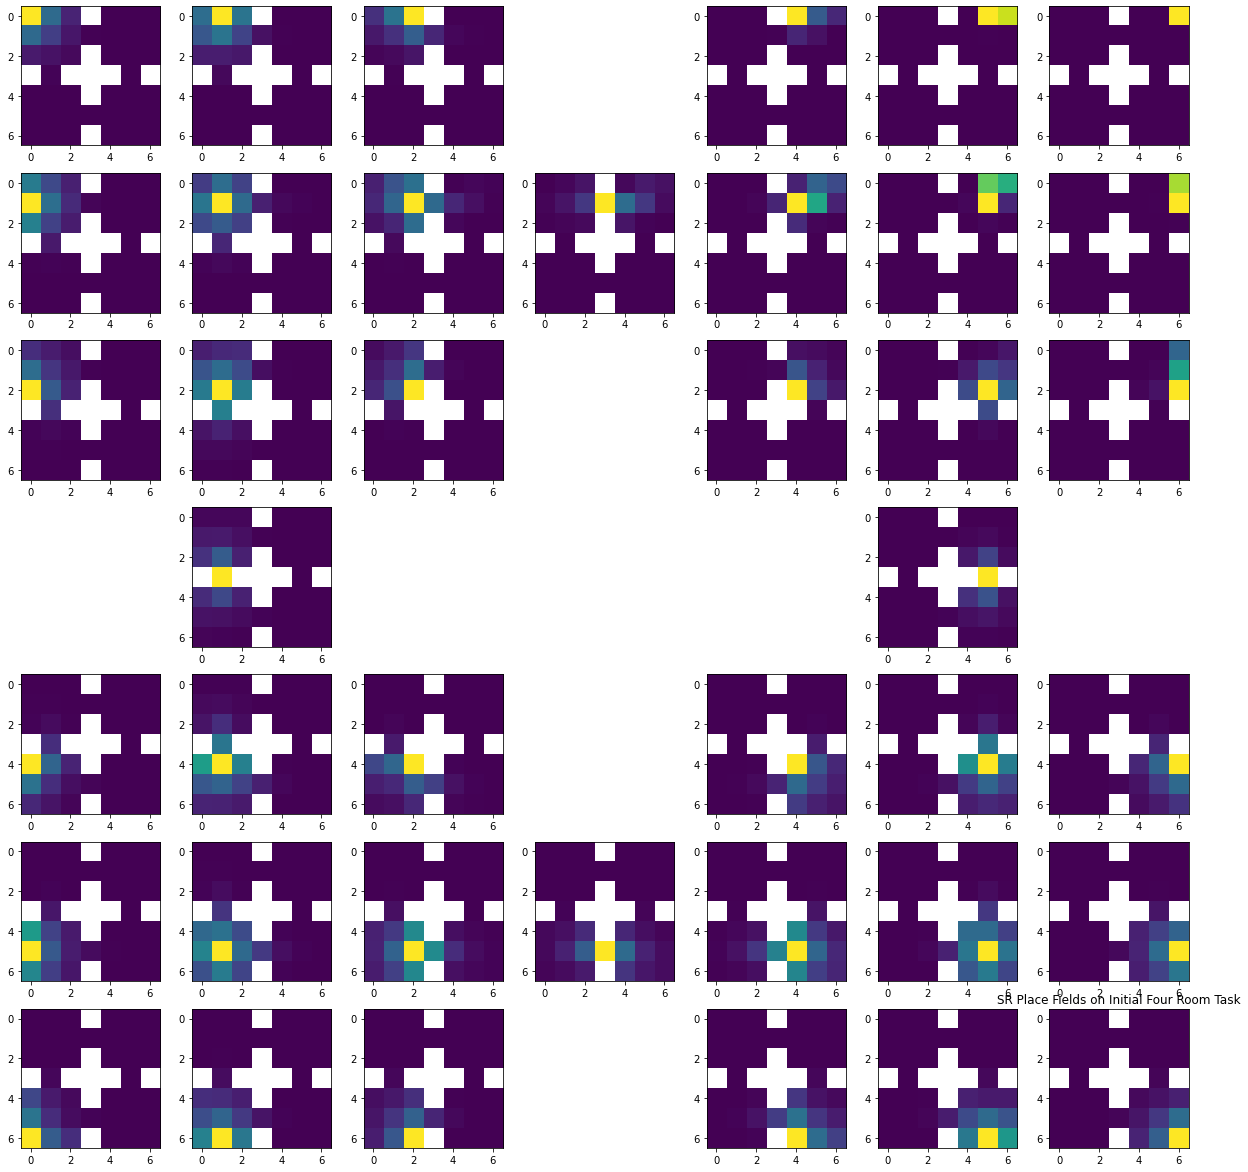

In [5]:
plot_place_fields(agent_ps, env, epsilon=epsilon_train, beta=beta_train)
plt.title("SR Place Fields on Initial Four Room Task");

## Introduce the Block

A wall is introduced to the four rooms environment that blocks the optimal path to the goal, forcing a detour. To inform the agent of the wall's existence, we train the agent by repetition of the following experience for `n_blocksteps = 60` time steps:

 * The agent starts to the left of the new wall, takes the action "go right", and consequently stays in the same state.
 * The agent starts on the wall, takes a random action, and remains in the same state, on the wall.

Between these experiences, the agent is allowed to use recall to update the SR in other states.

In [6]:
pattern="four_rooms_blocked"
env = SimpleGrid(grid_size, block_pattern=pattern, obs_mode="index")
mid = int(grid_size // 2)
earl_mid = int(mid // 2)
agent_detour_pos = [earl_mid, mid-1]
prioritized_states = np.zeros(env.state_size)

for i in progressbar.progressbar(range(n_blocksteps)):
    
    # start agent to the left of new wall
    env.reset(agent_pos=agent_detour_pos, goal_pos=goal_pos)
    state = env.observation
    # make agent try to go to the right
    action = 3
    reward = env.step(action)
    state_next = env.observation
    done = env.done
    experiences.append([state, action, state_next, reward, done])
    # perform update 
    td_sr = memory_update(experiences[-1], agent_ps, epsilon=epsilon_train, beta=beta_train)
    if (np.linalg.norm(td_sr) > theta):
        pqueue.push(experiences[-1], -np.linalg.norm(td_sr))
        
#     exp_weights.append(1)
#     mem_indices = get_dyna_indices(experiences, exp_weights, n_mem)
#     mem = [experiences[t] for t in mem_indices]
#     for exp in mem:
#         prioritized_states[exp[0]] += 1
#         td_sr = memory_update(exp, agent_ps, epsilon=epsilon_train, beta=beta_train)
        
    for k in range(n_mem):
            
        if pqueue.is_empty():
            break

        # get highest priority item and remove
        exp = pqueue.pop()

        prioritized_states[exp[0]] += 1

        td_sr = memory_update(exp, agent_ps, epsilon=epsilon_train, beta=beta_train)                

        for exp_pred in get_predecessors(exp[0], experiences):
            td_sr = memory_update(exp_pred, agent_ps, epsilon=epsilon_train, beta=beta_train)                    
            if (np.linalg.norm(td_sr) > theta):
                pqueue.push(exp_pred, -np.linalg.norm(td_sr))

100% (60 of 60) |########################| Elapsed Time: 0:07:24 Time:  0:07:24


In [7]:
agent_wall_pos = [earl_mid, mid]

for i in progressbar.progressbar(range(n_blocksteps)):
    
    # start agent on the wall
    env.reset(agent_pos=agent_wall_pos, goal_pos=goal_pos)
    state = env.observation
    action = npr.choice(4)
    reward = 0
    state_next = env.observation
    done = env.done
    experiences.append([state, action, state_next, reward, done])
    # perform update 
    td_sr = memory_update(experiences[-1], agent_ps, epsilon=epsilon_train, beta=beta_train)
    if (np.linalg.norm(td_sr) > theta):
        pqueue.push(experiences[-1], -np.linalg.norm(td_sr))
        
#     exp_weights.append(1)
#     mem_indices = get_dyna_indices(experiences, exp_weights, n_mem)
#     mem = [experiences[t] for t in mem_indices]
#     for exp in mem:
#         prioritized_states[exp[0]] += 1
#         td_sr = memory_update(exp, agent_ps, epsilon=epsilon_train, beta=beta_train)
        
    for k in range(n_mem):
            
        if pqueue.is_empty():
            break

        # get highest priority item and remove
        exp = pqueue.pop()

        prioritized_states[exp[0]] += 1

        td_sr = memory_update(exp, agent_ps, epsilon=epsilon_train, beta=beta_train)                

        for exp_pred in get_predecessors(exp[0], experiences):
            td_sr = memory_update(exp_pred, agent_ps, epsilon=epsilon_train, beta=beta_train)                    
            if (np.linalg.norm(td_sr) > theta):
                pqueue.push(exp_pred, -np.linalg.norm(td_sr))

100% (60 of 60) |########################| Elapsed Time: 0:09:31 Time:  0:09:31


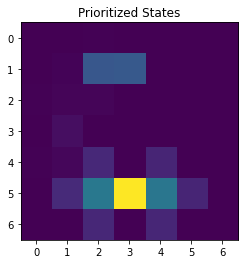

In [8]:
# plt.imshow(utils.mask_grid(prioritized_states.reshape(grid_size, grid_size), env.blocks), cmap=cmap);
plt.imshow(prioritized_states.reshape(grid_size, grid_size), cmap=cmap);
plt.title('Prioritized States');

## Test the Agent

The agent must now navigate from the top-left state to the goal in the top-right, without further updates to the SR.

In [9]:
ep_lengths = []
errors = []

for i in progressbar.progressbar(range(episodes_test)):
    
    ep_experiences = []
    env.reset(agent_pos=agent_pos, goal_pos=goal_pos)
    state = env.observation

    for j in range(episode_length):
        action = agent_ps.sample_action(state, epsilon=epsilon_test, beta=beta_test)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        ep_experiences.append([state, action, state_next, reward, done])        
        state = state_next
                        
        if env.done:
            break
            
    ep_lengths.append(len(ep_experiences))
            
av_ep_length_ps = int(np.mean(ep_lengths))
print(f"Average episode length: {av_ep_length_ps}")
print(f"Optimal episode length: 16")

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Average episode length: 16
Optimal episode length: 16


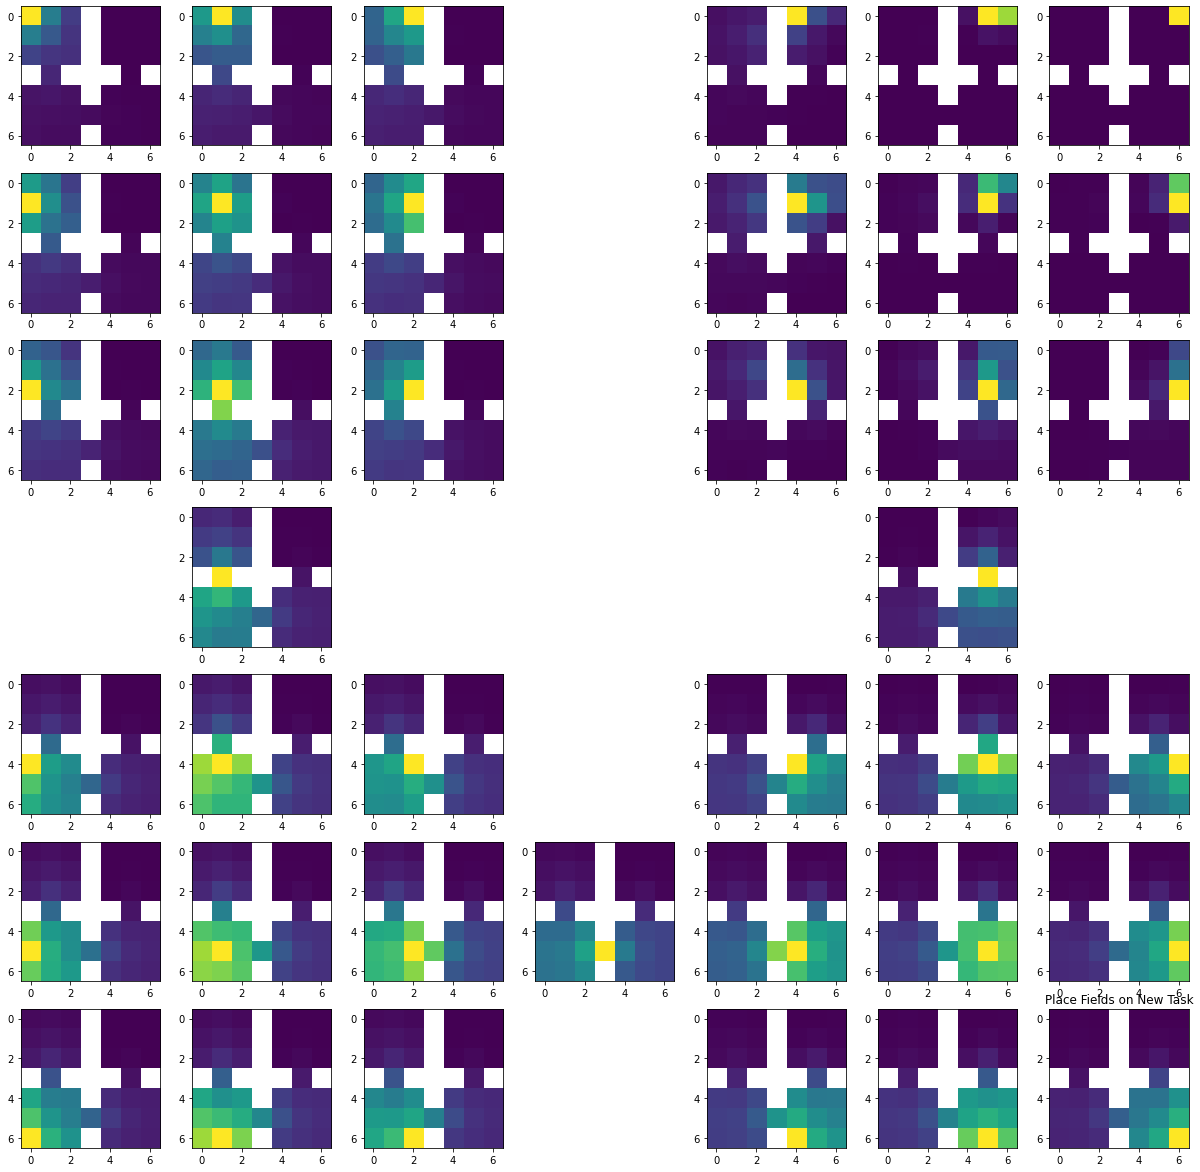

In [12]:
plot_place_fields(agent_ps, env, epsilon=epsilon_train, beta=beta_train)
plt.title("Place Fields on New Task");

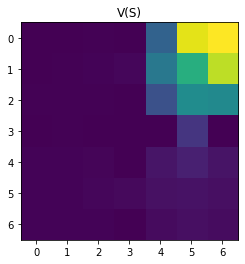

In [11]:
Q = agent_ps.M @ agent_ps.w
# plt.imshow(utils.mask_grid(Q.max(0).reshape(grid_size, grid_size), env.blocks), cmap=cmap);
plt.imshow(Q.max(0).reshape(grid_size, grid_size), cmap=cmap);
plt.title("V(S)");

## Things you can try

* Use SR-Dyna instead of SR-PS (it requires commenting / uncommenting some code). It runs more quickly, but doesn't solve the task.
* Vary some of the experiment parameters, like the softmax policy inverse temperature, the number of recall steps, the number of initial training episodes, or the number of training episodes with the new wall.
* Remove one of the new wall initialisation experiences.